In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid", context="notebook")

plt.rcParams.update({
    'figure.facecolor': '#0D1B2A',     # deep navy blue
    'axes.facecolor': '#0D1B2A',
    'axes.edgecolor': '#E0E1DD',
    'axes.labelcolor': '#E0E1DD',
    'text.color': '#E0E1DD',
    'xtick.color': '#E0E1DD',
    'ytick.color': '#E0E1DD',
    'grid.color': '#1B263B',
    'legend.facecolor': '#1B263B',
    'legend.edgecolor': '#E0E1DD',
    'font.family': 'DejaVu Sans',
    'figure.dpi': 150
})


In [2]:
# Loading data 

train_df = pd.read_csv('../data/cleaned_train.csv')
test_df = pd.read_csv('../data/cleaned_test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Number of features: {train_df.shape[1] - 2}")

# ==================== Data Preparation ====================

X_train = train_df.drop(['subject', 'Activity'], axis=1)
y_train = train_df['Activity']

X_test = test_df.drop(['subject', 'Activity'], axis=1)
y_test = test_df['Activity']

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Number of activity classes: {y_train.nunique()}")
print(f"\nActivity distribution in training set:")
print(y_train.value_counts().sort_index())

# ==================== Feature Scaling ====================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training data shape: (7352, 563)
Test data shape: (2947, 563)
Number of features: 561

Feature matrix shape: (7352, 561)
Number of activity classes: 6

Activity distribution in training set:
Activity
0    1407
1    1286
2    1374
3    1226
4     986
5    1073
Name: count, dtype: int64


Original number of features: 561

Components needed to explain:
  90% variance: 63 components
  95% variance: 102 components
  99% variance: 179 components


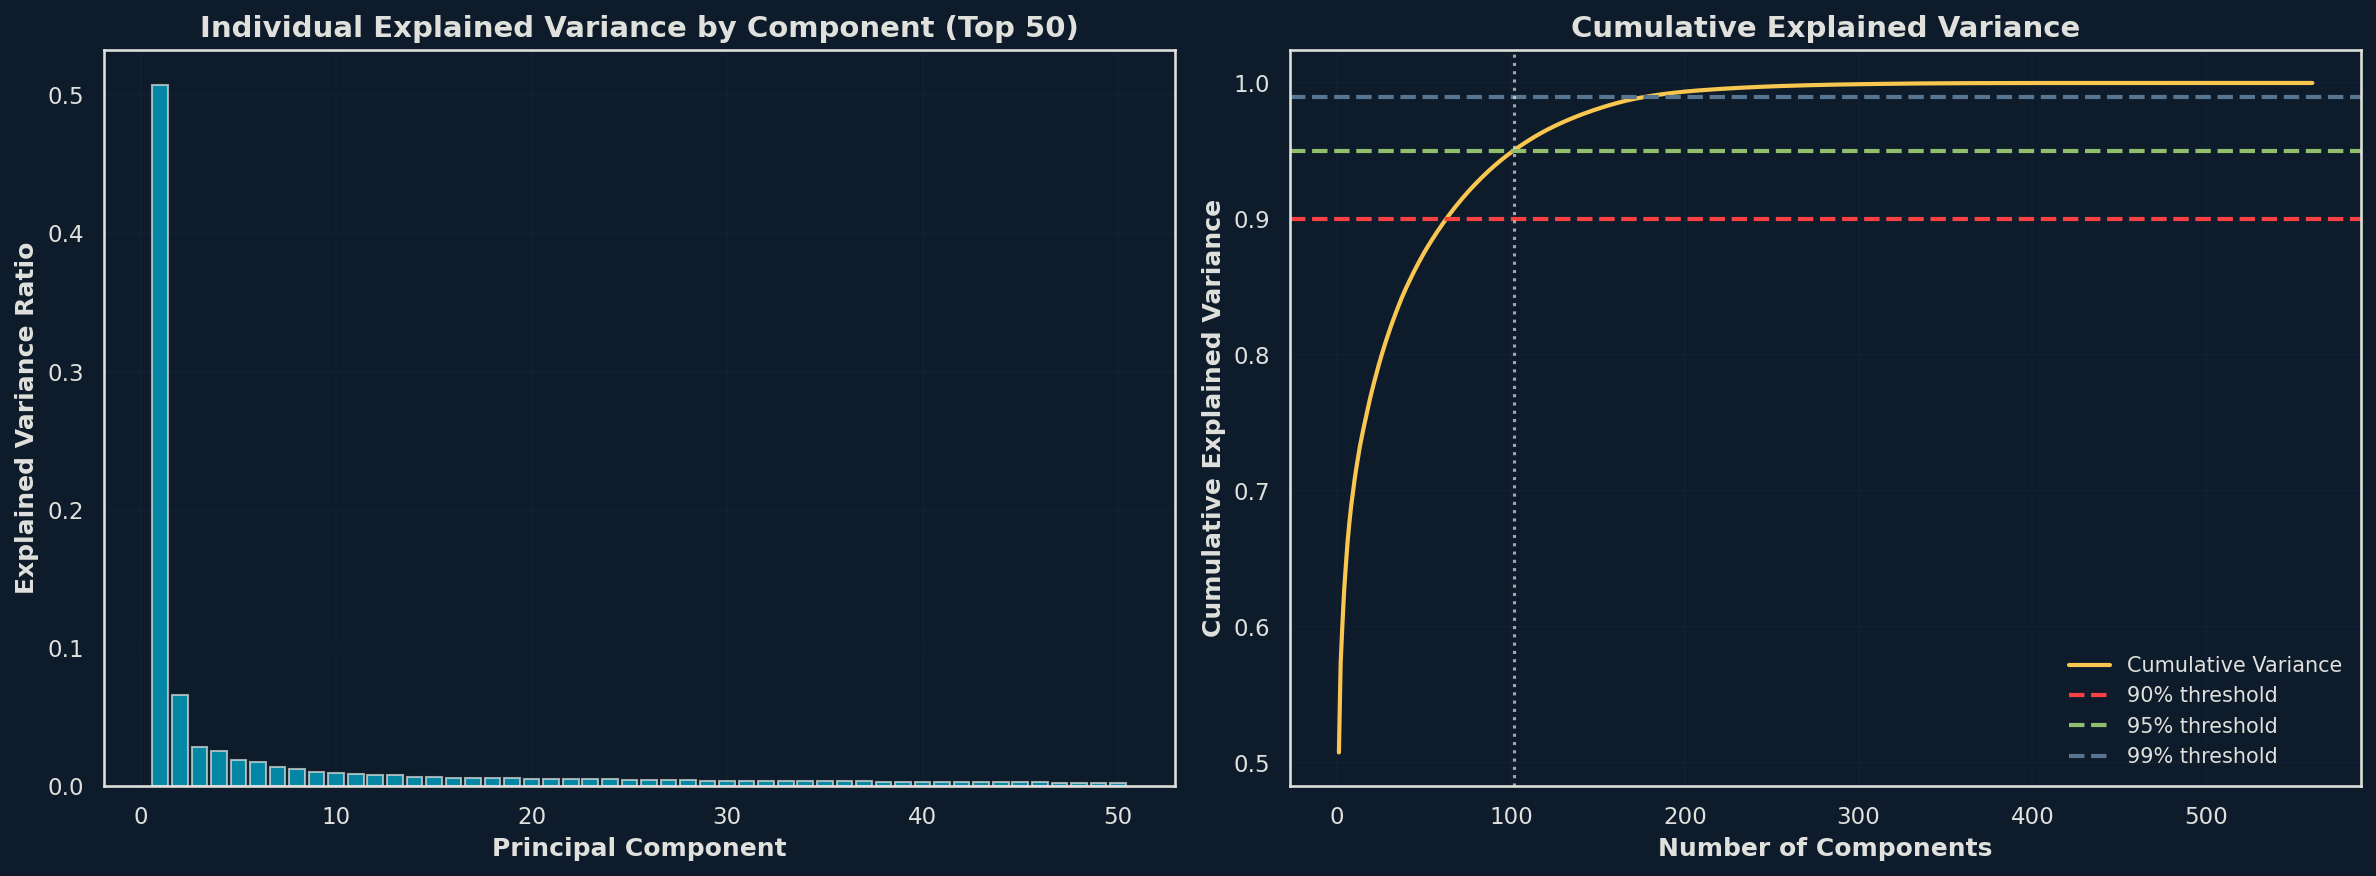

In [3]:
# ==================== PCA: Explained Variance Analysis ====================

pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1

print(f"Original number of features: {X_train.shape[1]}")
print(f"\nComponents needed to explain:")
print(f"  90% variance: {n_components_90} components")
print(f"  95% variance: {n_components_95} components")
print(f"  99% variance: {n_components_99} components")

# ==================== Visualization: Explained Variance ====================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, min(51, len(explained_variance_ratio) + 1)),
            explained_variance_ratio[:50],
            alpha=0.7, color='#00B4D8', edgecolor='#E0E1DD')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Individual Explained Variance by Component (Top 50)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance_ratio) + 1),
             cumulative_variance_ratio, color='#F9C74F', linewidth=2,
             label='Cumulative Variance')
axes[1].axhline(y=0.90, color='#F94144', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=0.95, color='#90BE6D', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axhline(y=0.99, color='#577590', linestyle='--', linewidth=2, label='99% threshold')
axes[1].axvline(x=n_components_95, color='#E0E1DD', linestyle=':', alpha=0.7)
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("pca_variance_analysis_dark.png", bbox_inches='tight', dpi=300, facecolor=plt.gcf().get_facecolor())
plt.show()



In [4]:
# ==================== PCA Transformation (95% variance) ====================
n_components_optimal = n_components_95
pca = PCA(n_components=n_components_optimal)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Selected number of components: {n_components_optimal}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {X_train.shape[1]} → {X_train_pca.shape[1]}")
print(f"Compression ratio: {(1 - n_components_optimal/X_train.shape[1])*100:.2f}%")

print(f"\nTransformed data shapes:")
print(f"  Training: {X_train_pca.shape}")
print(f"  Test: {X_test_pca.shape}")



Selected number of components: 102
Total variance explained: 0.9504
Dimensionality reduction: 561 → 102
Compression ratio: 81.82%

Transformed data shapes:
  Training: (7352, 102)
  Test: (2947, 102)


In [5]:
# ==================== Component Analysis ====================

n_top_components = min(5, n_components_optimal)
print(f"\nTop {n_top_components} components:")
for i in range(n_top_components):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}% variance")
    loadings = pca.components_[i]
    top_features_idx = np.argsort(np.abs(loadings))[-5:][::-1]
    print(f"       Top contributing features:")
    for idx in top_features_idx:
        print(f"         - {X_train.columns[idx]}: {loadings[idx]:.4f}")



Top 5 components:
  PC1: 50.78% variance
       Top contributing features:
         - fBodyAcc-sma(): 0.0586
         - fBodyAccJerk-sma(): 0.0586
         - tBodyAccJerk-sma(): 0.0585
         - fBodyGyro-sma(): 0.0585
         - tBodyAccJerkMag-mean(): 0.0585
  PC2: 6.58% variance
       Top contributing features:
         - fBodyAcc-meanFreq()-Z: 0.1224
         - tBodyGyroMag-arCoeff()1: 0.1198
         - tBodyAccMag-arCoeff()1: 0.1182
         - tGravityAccMag-arCoeff()1: 0.1182
         - fBodyAccMag-meanFreq(): 0.1179
  PC3: 2.81% variance
       Top contributing features:
         - tGravityAcc-energy()-X: -0.1101
         - tGravityAcc-arCoeff()-X,1: -0.1099
         - tGravityAcc-entropy()-Y: 0.1096
         - tGravityAcc-energy()-Z: 0.1091
         - tGravityAcc-min()-X: -0.1082
  PC4: 2.50% variance
       Top contributing features:
         - tGravityAcc-max()-Z: -0.1440
         - tGravityAcc-mean()-Z: -0.1410
         - angle(Z,gravityMean): 0.1399
         - tGravityAc

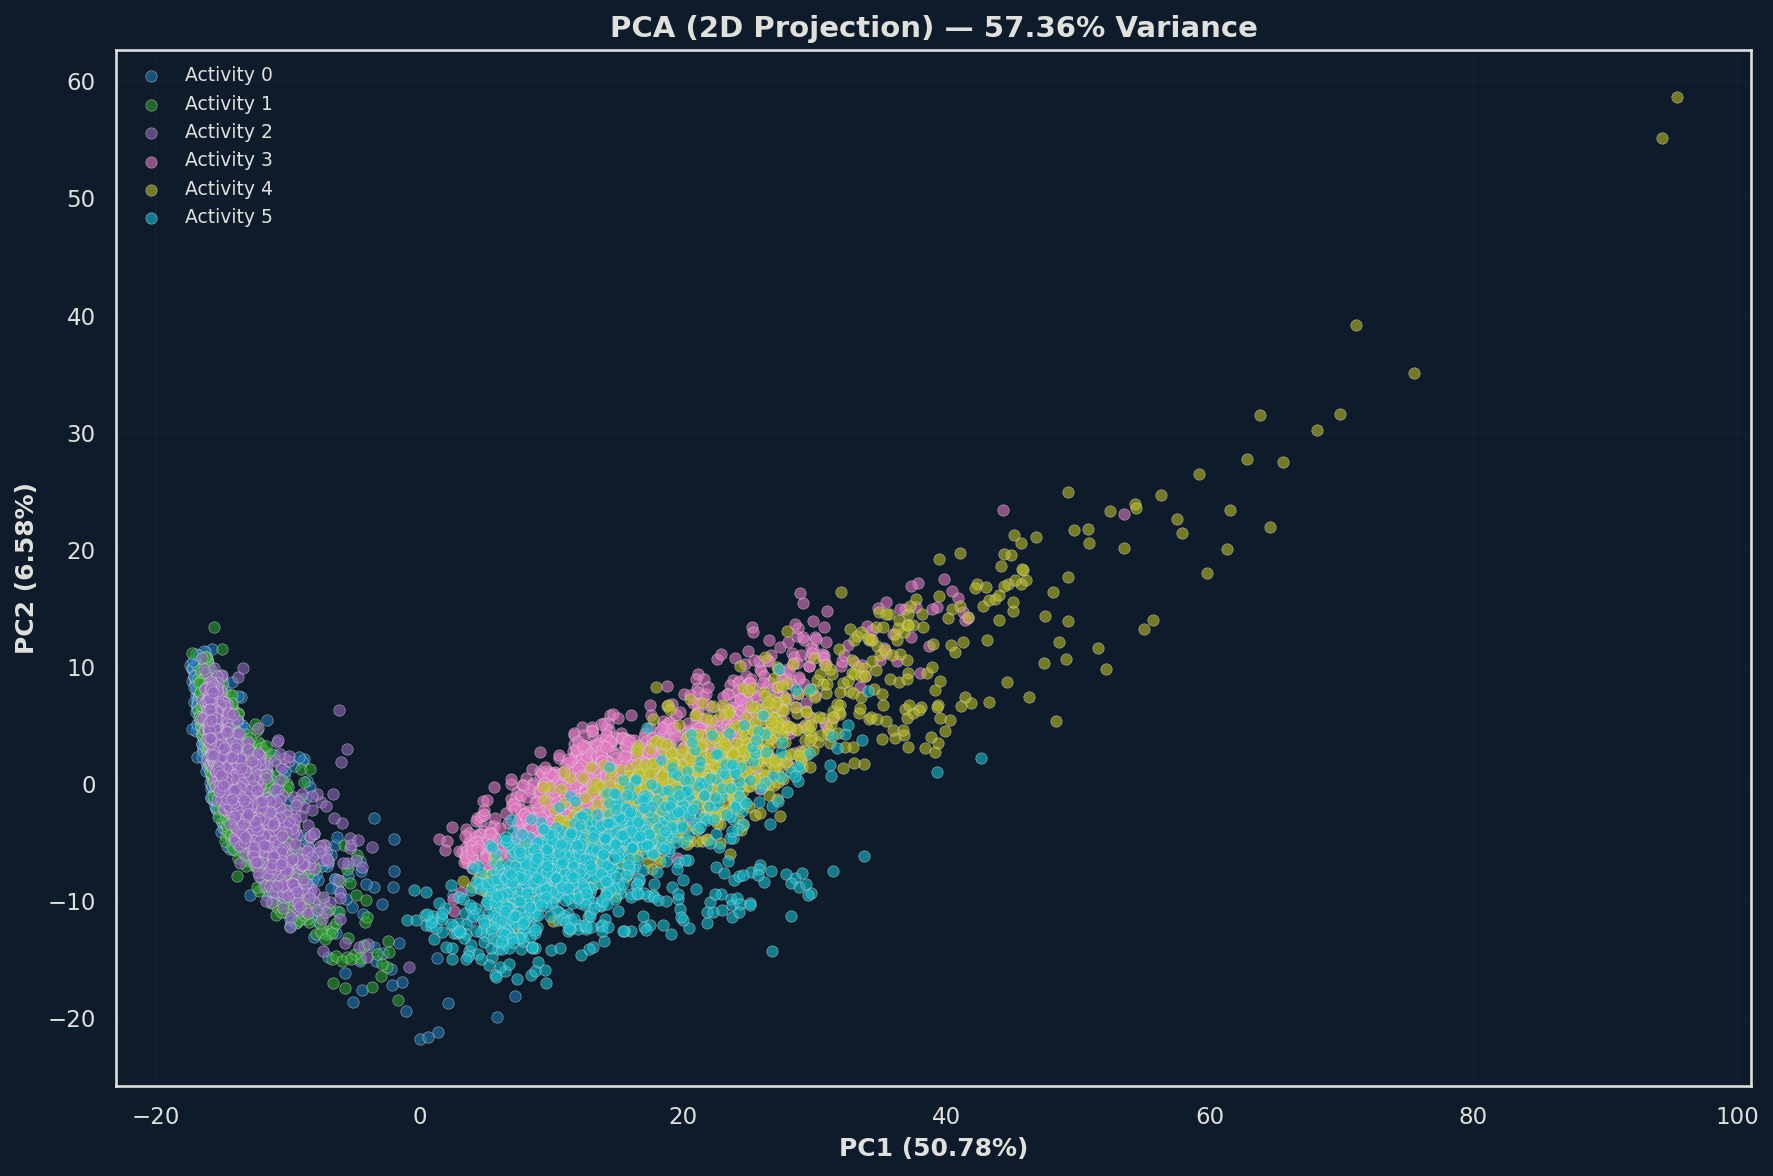

In [6]:
# ==================== 2D Visualization ====================

fig, ax = plt.subplots(figsize=(12, 8))
unique_activities = sorted(y_train.unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_activities)))

for activity, color in zip(unique_activities, colors):
    mask = y_train == activity
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
               c=[color], label=f'Activity {activity}', alpha=0.6, s=30,
               edgecolors='#E0E1DD', linewidth=0.3)

var_2d = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12, fontweight='bold')
ax.set_title(f'PCA (2D Projection) — {var_2d*100:.2f}% Variance', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("pca_2d_projection_dark.png", bbox_inches='tight', dpi=300, facecolor=plt.gcf().get_facecolor())
plt.show()

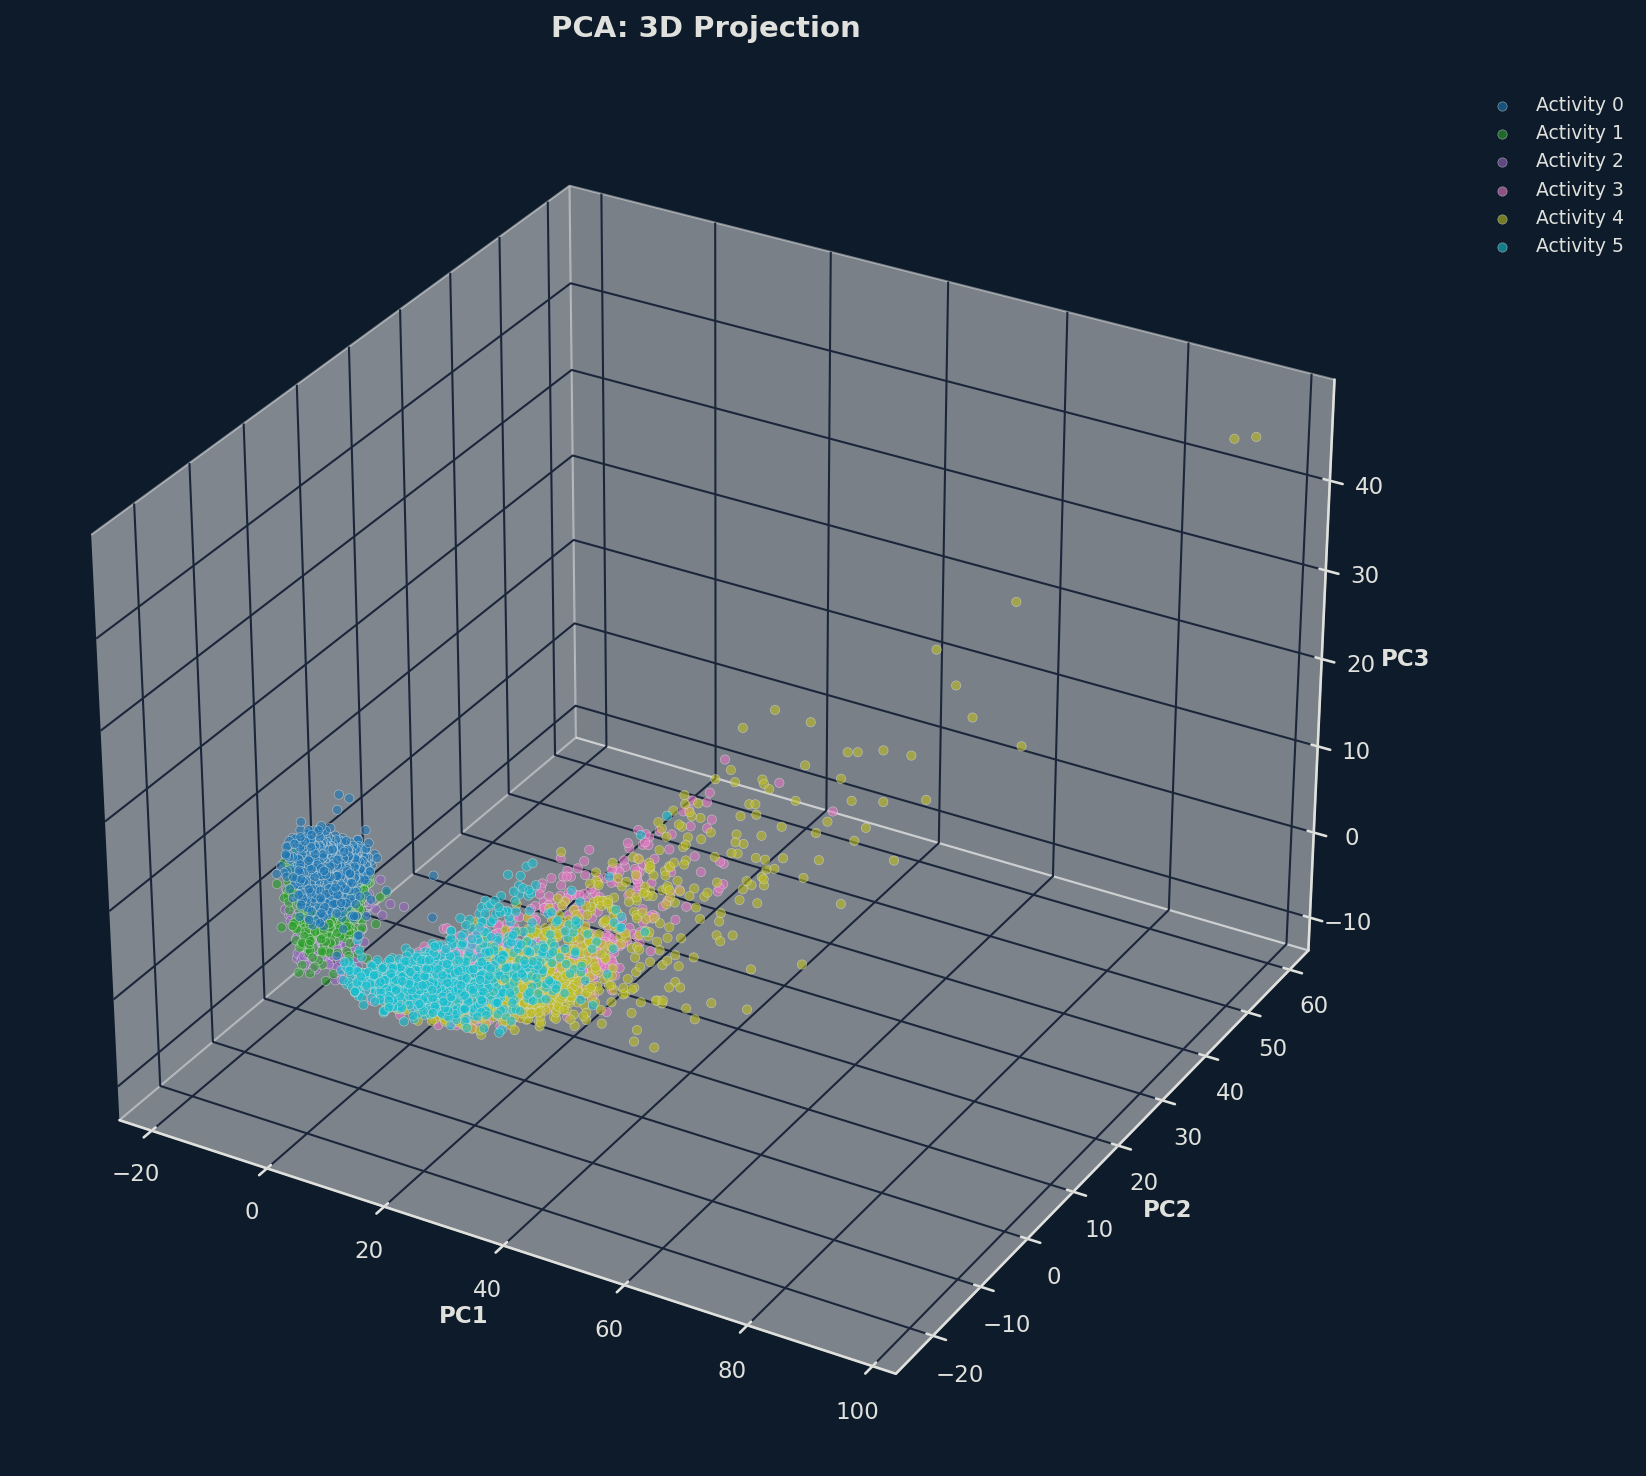

In [11]:
if n_components_optimal >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    for activity, color in zip(unique_activities, colors):
        mask = y_train == activity
        ax.scatter(X_train_pca[mask, 0],
                   X_train_pca[mask, 1],
                   X_train_pca[mask, 2],
                   c=[color], label=f'Activity {activity}',
                   alpha=0.6, s=20,
                   edgecolors='#E0E1DD', linewidth=0.3)

    ax.set_xlabel('PC1', fontsize=11, fontweight='bold', color='#E0E1DD')
    ax.set_ylabel('PC2', fontsize=11, fontweight='bold', color='#E0E1DD')
    ax.set_zlabel('PC3', fontsize=11, fontweight='bold', color='#E0E1DD')
    ax.set_title('PCA: 3D Projection', fontsize=14, fontweight='bold', pad=20, color='#E0E1DD')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, framealpha=0.9)

    plt.tight_layout()
    plt.savefig("pca_3d_projection_dark.png", bbox_inches='tight', dpi=300, facecolor=plt.gcf().get_facecolor())
    plt.show()
else:
    print(f"3D plot skipped: PCA has only {n_components_optimal} components.")


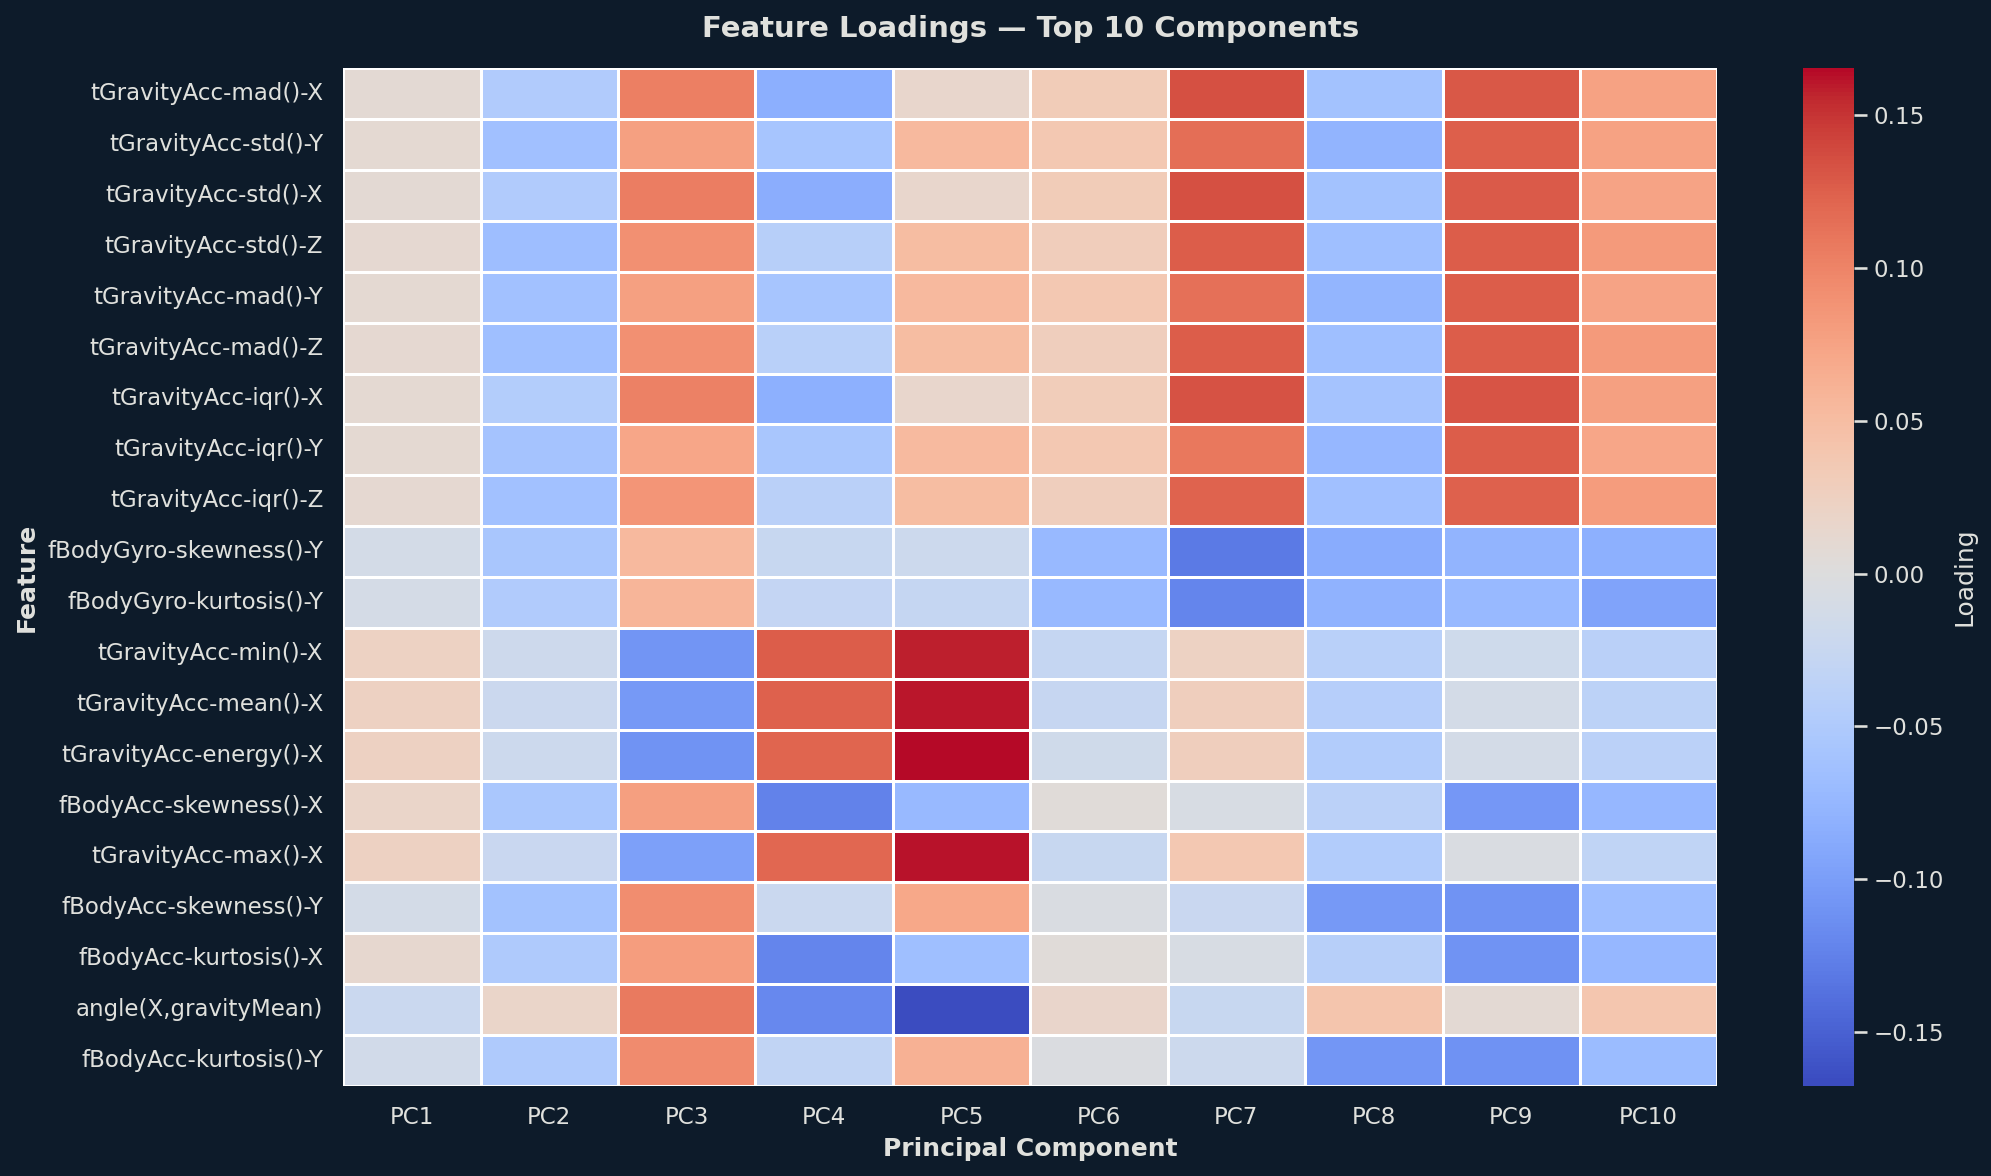


Top 10 most important features:
   1. tGravityAcc-mad()-X: 0.6954
   2. tGravityAcc-std()-Y: 0.6952
   3. tGravityAcc-std()-X: 0.6939
   4. tGravityAcc-std()-Z: 0.6923
   5. tGravityAcc-mad()-Y: 0.6920
   6. tGravityAcc-mad()-Z: 0.6897
   7. tGravityAcc-iqr()-X: 0.6879
   8. tGravityAcc-iqr()-Y: 0.6713
   9. tGravityAcc-iqr()-Z: 0.6710
  10. fBodyGyro-skewness()-Y: 0.6174


In [12]:
# ==================== Feature Loadings Heatmap ====================

n_display = min(10, n_components_optimal)
loadings_df = pd.DataFrame(pca.components_[:n_display],
                           columns=X_train.columns,
                           index=[f'PC{i+1}' for i in range(n_display)])

feature_importance = np.abs(loadings_df).sum(axis=0).sort_values(ascending=False)
top_features = feature_importance.head(20).index

plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df[top_features].T, cmap='coolwarm', center=0,
            cbar_kws={'label': 'Loading'}, linewidths=0.5)
plt.title(f'Feature Loadings — Top {n_display} Components', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Principal Component', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("pca_feature_loadings_dark.png", bbox_inches='tight', dpi=300, facecolor=plt.gcf().get_facecolor())
plt.show()

print("\nTop 10 most important features:")
for i, (feature, importance) in enumerate(feature_importance.head(10).items(), 1):
    print(f"  {i:2d}. {feature}: {importance:.4f}")

In [9]:
# ==================== Save PCA Results ====================

train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components_optimal)])
train_pca_df['Activity'] = y_train.values
train_pca_df['subject'] = train_df['subject'].values

test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components_optimal)])
test_pca_df['Activity'] = y_test.values
test_pca_df['subject'] = test_df['subject'].values

train_pca_df.to_csv('../data/train_pca.csv', index=False)
test_pca_df.to_csv('../data/test_pca.csv', index=False)

print("✓ PCA-transformed training data saved to: ../data/train_pca.csv")
print("✓ PCA-transformed test data saved to: ../data/test_pca.csv")


✓ PCA-transformed training data saved to: ../data/train_pca.csv
✓ PCA-transformed test data saved to: ../data/test_pca.csv


In [10]:
# ==================== Summary Statistics ====================

print(f"Original dimensions: {X_train.shape[1]} features")
print(f"Reduced dimensions: {n_components_optimal} principal components")
print(f"Variance preserved: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"Dimensionality reduction: {(1 - n_components_optimal/X_train.shape[1])*100:.2f}%")
print(f"\nData is ready for clustering analysis!")


Original dimensions: 561 features
Reduced dimensions: 102 principal components
Variance preserved: 95.04%
Dimensionality reduction: 81.82%

Data is ready for clustering analysis!


## UNSUPERVISED LEARNING: CLUSTERING (KMeans + GMM + Insights)


In [13]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, homogeneity_score, silhouette_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


X_pca = X_train_pca
y_true = y_train.values
n_clusters = len(np.unique(y_true))

In [14]:
# ==================== KMeans ====================
print("\n--- KMeans Clustering ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_pca)

kmeans_ari = adjusted_rand_score(y_true, kmeans_labels)
kmeans_homo = homogeneity_score(y_true, kmeans_labels)
kmeans_sil = silhouette_score(X_pca, kmeans_labels)



--- KMeans Clustering ---


In [15]:
# ==================== GMM ====================
print("\n--- Gaussian Mixture Model (GMM) ---")
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

gmm_ari = adjusted_rand_score(y_true, gmm_labels)
gmm_homo = homogeneity_score(y_true, gmm_labels)
gmm_sil = silhouette_score(X_pca, gmm_labels)


--- Gaussian Mixture Model (GMM) ---


In [16]:
# ==================== Metrics Summary ====================
metrics_df = pd.DataFrame({
    'Model': ['KMeans', 'GMM'],
    'ARI': [kmeans_ari, gmm_ari],
    'Homogeneity': [kmeans_homo, gmm_homo],
    'Silhouette': [kmeans_sil, gmm_sil]
})
metrics_df['Rank'] = metrics_df[['ARI','Homogeneity','Silhouette']].mean(axis=1).rank(ascending=False)
metrics_df = metrics_df.sort_values('Rank')
print("\n--- Metric Summary ---")
print(metrics_df.round(4))

best_model = metrics_df.iloc[0]['Model']
print(f"\n Best clustering model overall: {best_model}")


--- Metric Summary ---
    Model     ARI  Homogeneity  Silhouette  Rank
0  KMeans  0.4196       0.5414      0.1217   1.0
1     GMM  0.2967       0.4353      0.1426   2.0

 Best clustering model overall: KMeans


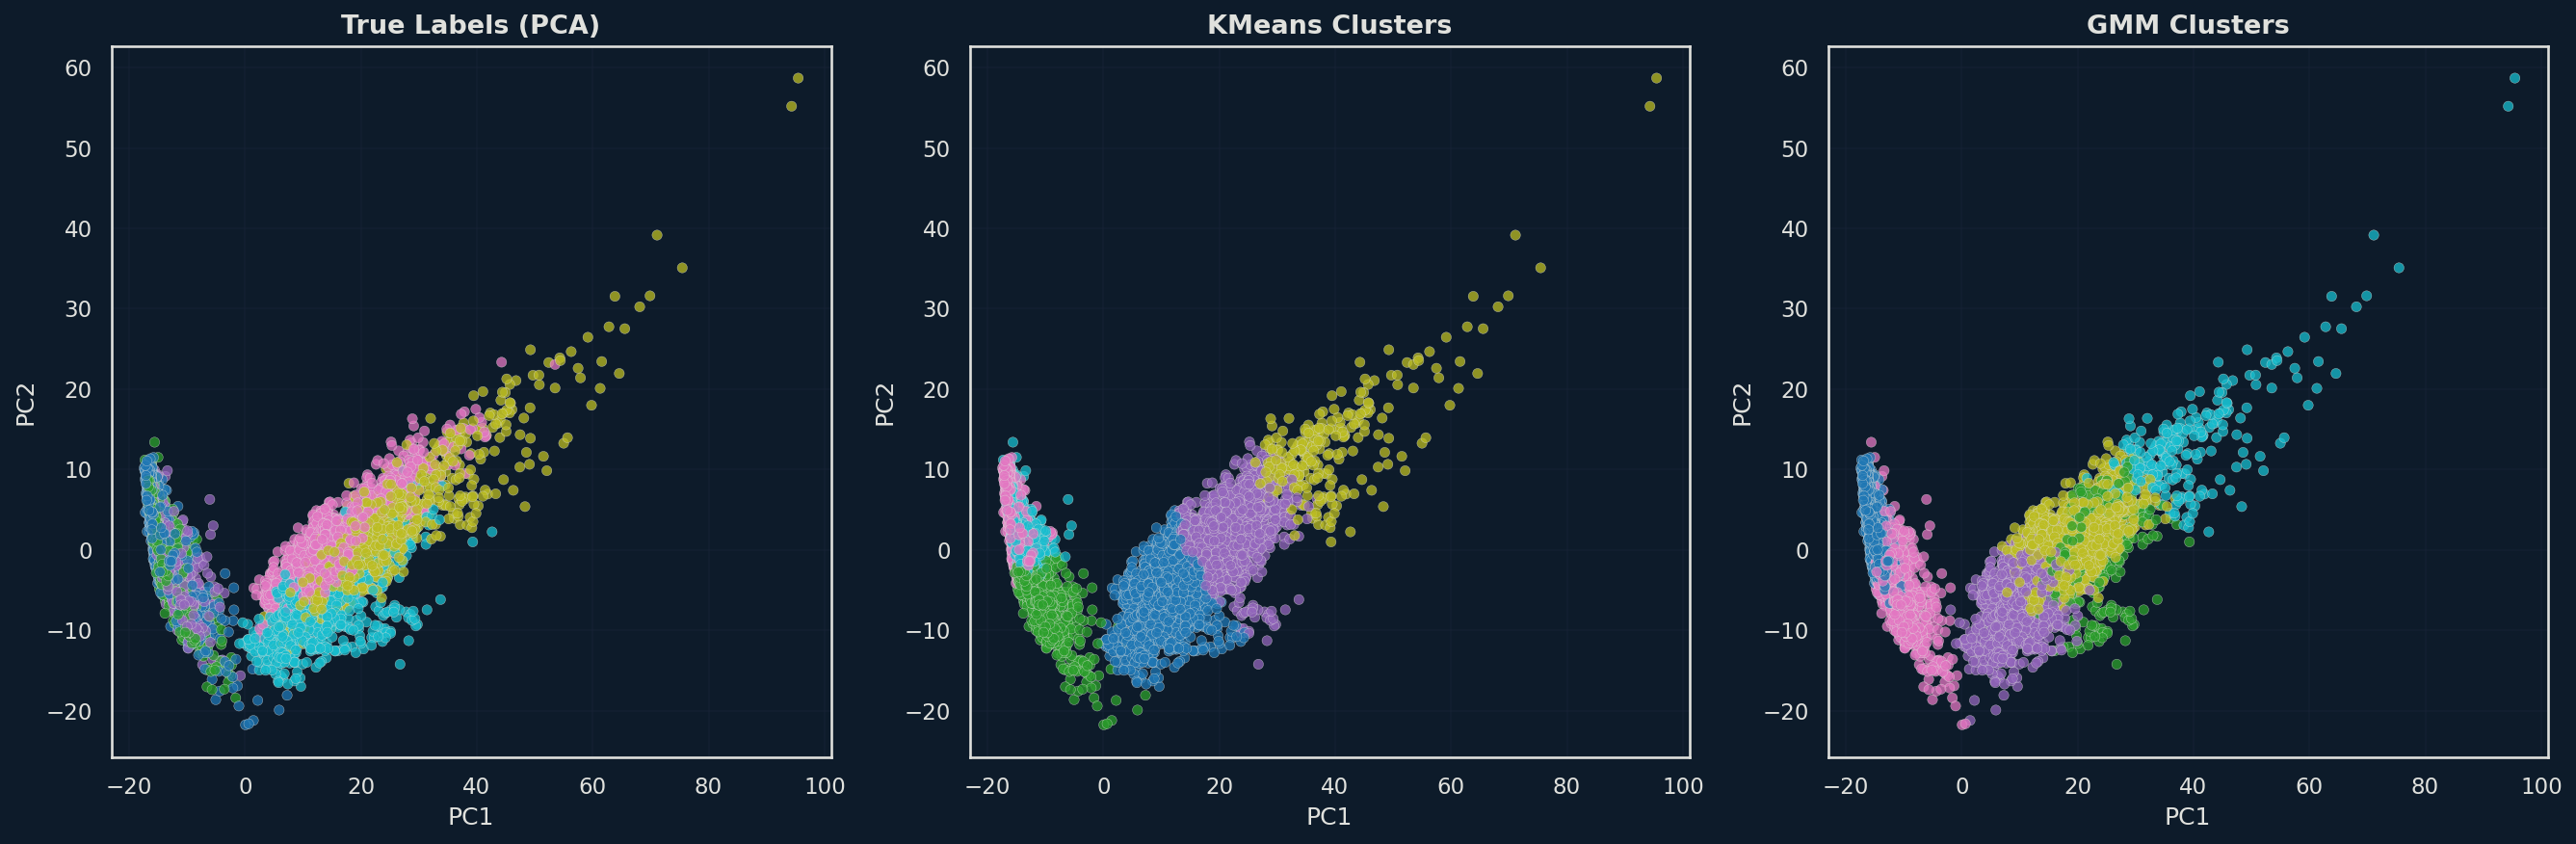

In [17]:
# 2D Scatter Comparison

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='#0D1B2A')
titles = ['True Labels (PCA)', 'KMeans Clusters', 'GMM Clusters']
datasets = [y_true, kmeans_labels, gmm_labels]
cmaps = [plt.cm.tab10]*3

for ax, title, labels, cmap in zip(axes, titles, datasets, cmaps):
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap, s=25, alpha=0.75,
               edgecolors='#E0E1DD', linewidth=0.2)
    ax.set_title(title, fontsize=13, fontweight='bold', color='#E0E1DD')
    ax.set_xlabel('PC1', color='#E0E1DD')
    ax.set_ylabel('PC2', color='#E0E1DD')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("clustering_comparison_dark.png", dpi=300, bbox_inches='tight',
            facecolor=plt.gcf().get_facecolor())
plt.show()

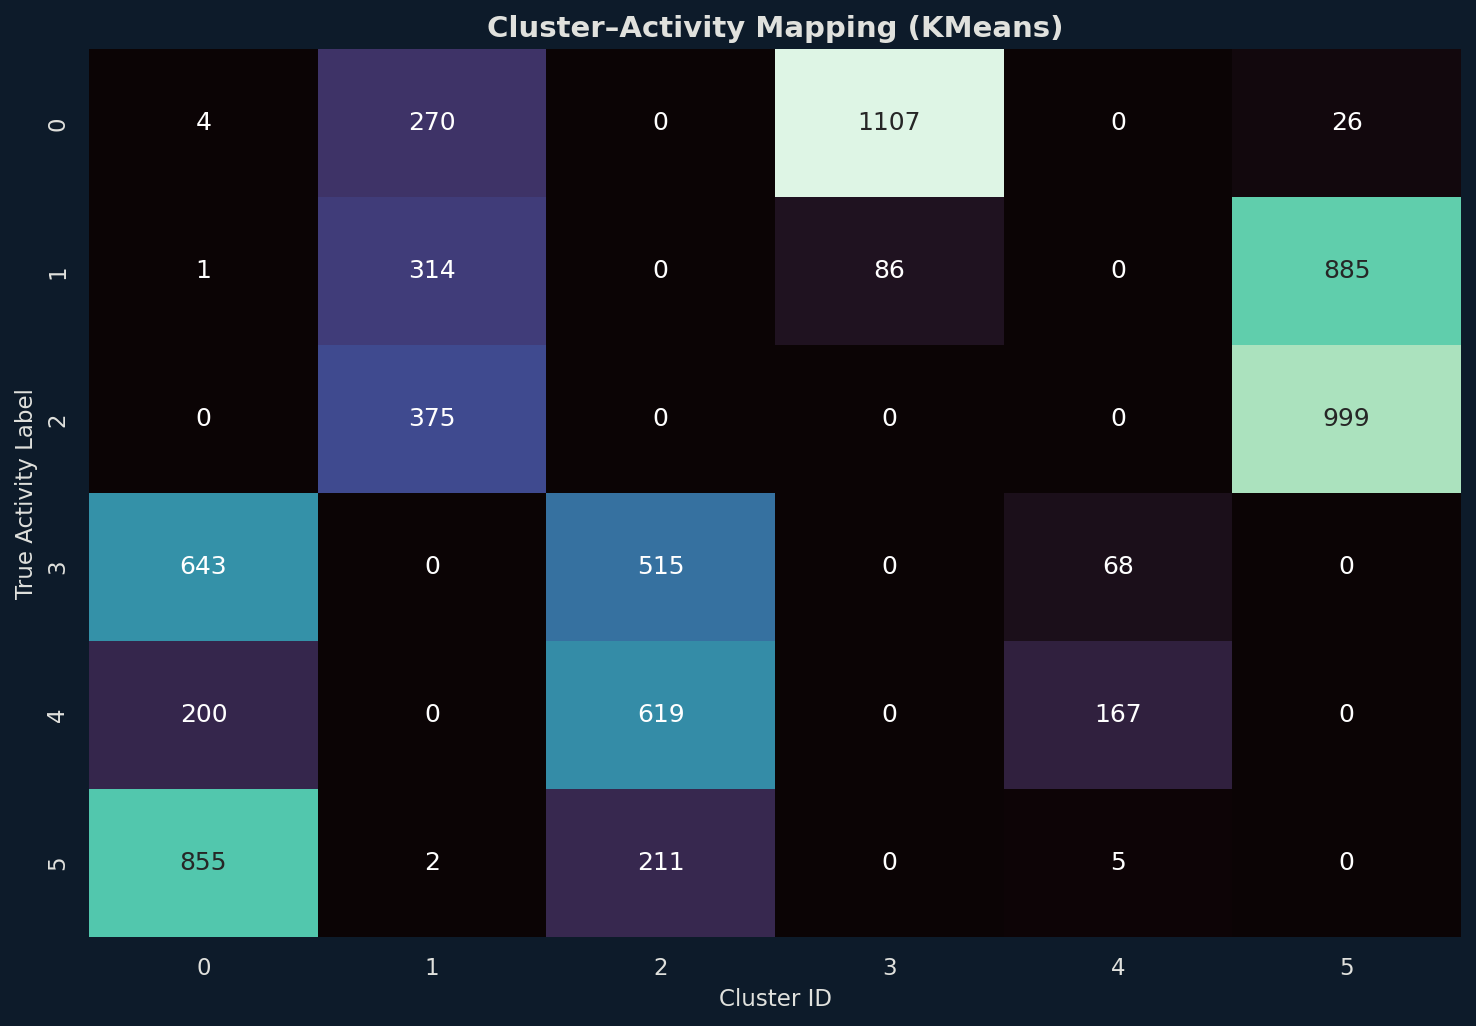

In [18]:
# Cluster–Activity Mapping (Confusion Heatmap)

kmeans_cm = confusion_matrix(y_true, kmeans_labels)
plt.figure(figsize=(10,7), facecolor='#0D1B2A')
sns.heatmap(kmeans_cm, cmap='mako', annot=True, fmt='d', cbar=False)
plt.title('Cluster–Activity Mapping (KMeans)', fontsize=14, fontweight='bold', color='#E0E1DD')
plt.xlabel('Cluster ID', fontsize=11, color='#E0E1DD')
plt.ylabel('True Activity Label', fontsize=11, color='#E0E1DD')
plt.tight_layout()
plt.savefig("cluster_activity_heatmap_dark.png", dpi=300, bbox_inches='tight',
            facecolor=plt.gcf().get_facecolor())
plt.show()

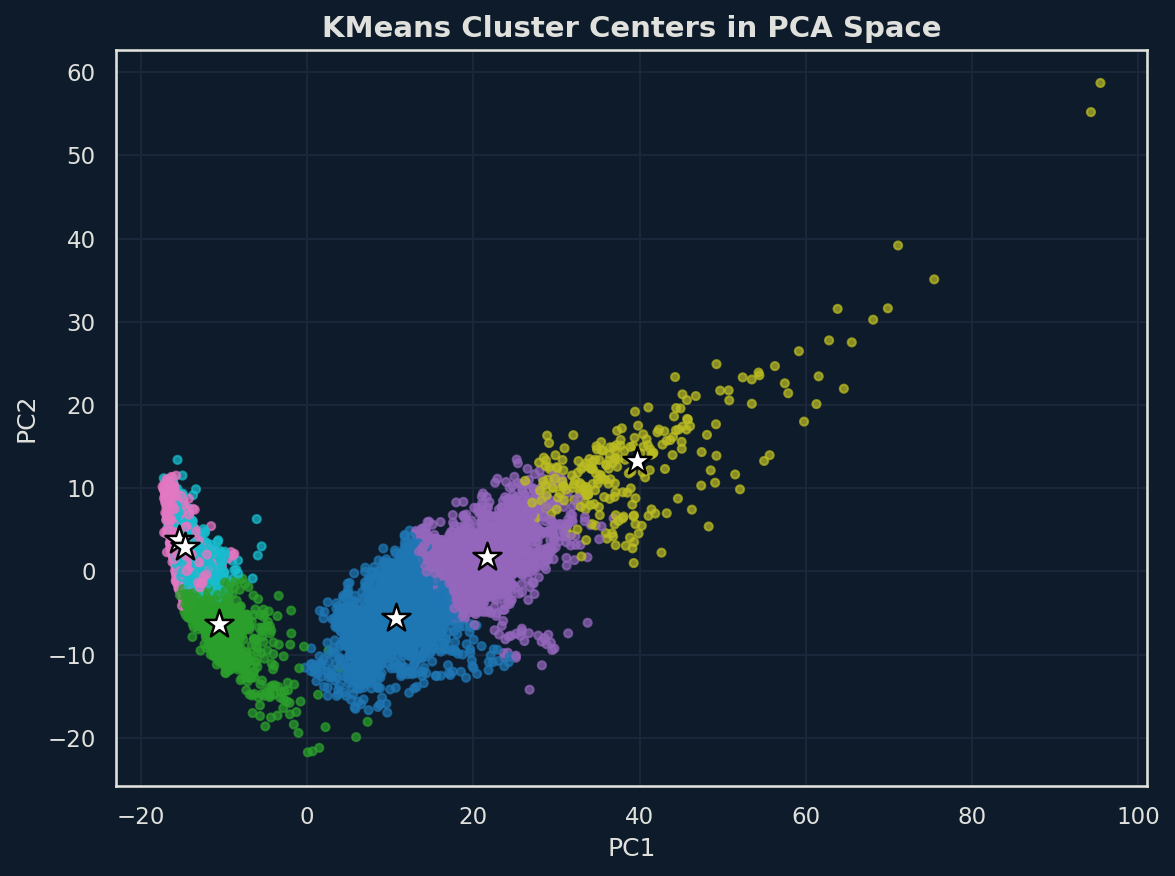

In [19]:
# Cluster Center Visualization (KMeans)

plt.figure(figsize=(8,6), facecolor='#0D1B2A')
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='tab10', s=15, alpha=0.7)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='white', s=200, marker='*', edgecolors='black', linewidths=1.2)
plt.title('KMeans Cluster Centers in PCA Space', fontsize=14, fontweight='bold', color='#E0E1DD')
plt.xlabel('PC1', color='#E0E1DD')
plt.ylabel('PC2', color='#E0E1DD')
plt.tight_layout()
plt.savefig("kmeans_cluster_centers_dark.png", dpi=300, bbox_inches='tight',
            facecolor=plt.gcf().get_facecolor())
plt.show()

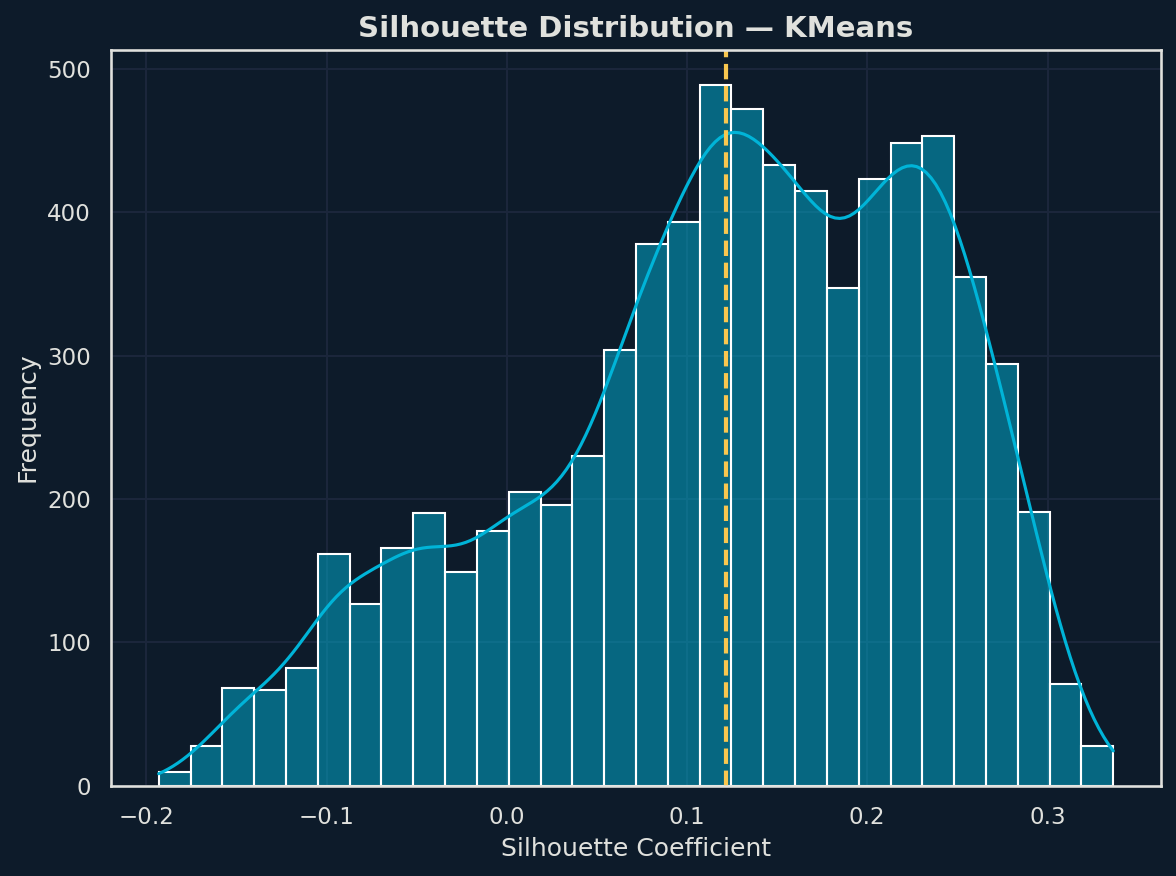

In [20]:
# Silhouette Distribution (Best Model)

from sklearn.metrics import silhouette_samples
labels_to_plot = kmeans_labels if best_model == 'KMeans' else gmm_labels
sil_values = silhouette_samples(X_pca, labels_to_plot)

plt.figure(figsize=(8,6), facecolor='#0D1B2A')
sns.histplot(sil_values, bins=30, kde=True, color='#00B4D8')
plt.axvline(np.mean(sil_values), color='#F9C74F', linestyle='--', linewidth=2)
plt.title(f'Silhouette Distribution — {best_model}', fontsize=14, fontweight='bold', color='#E0E1DD')
plt.xlabel('Silhouette Coefficient', color='#E0E1DD')
plt.ylabel('Frequency', color='#E0E1DD')
plt.tight_layout()
plt.savefig("silhouette_distribution_dark.png", dpi=300, bbox_inches='tight',
            facecolor=plt.gcf().get_facecolor())
plt.show()


In [21]:
#  Insights

print("INSIGHTS & OBSERVATIONS")

print(f"KMeans ARI={kmeans_ari:.4f}, Homogeneity={kmeans_homo:.4f}, Silhouette={kmeans_sil:.4f}")
print(f"GMM    ARI={gmm_ari:.4f}, Homogeneity={gmm_homo:.4f}, Silhouette={gmm_sil:.4f}")

print(f"\n Best overall performer: {best_model}")
print("• Cluster–activity heatmap shows how well clusters align with real labels.")
print("• Silhouette distribution reveals intra-cluster cohesion and separation.")
print("• PCA + clustering combination confirms that the reduced feature space")
print("  still retains strong structural patterns of the original activities.")


INSIGHTS & OBSERVATIONS
KMeans ARI=0.4196, Homogeneity=0.5414, Silhouette=0.1217
GMM    ARI=0.2967, Homogeneity=0.4353, Silhouette=0.1426

 Best overall performer: KMeans
• Cluster–activity heatmap shows how well clusters align with real labels.
• Silhouette distribution reveals intra-cluster cohesion and separation.
• PCA + clustering combination confirms that the reduced feature space
  still retains strong structural patterns of the original activities.


## SEQUENTIAL LEARNING: HIDDEN MARKOV MODEL (HMM)

In [25]:
from hmmlearn import hmm
from collections import Counter

# Prepare sequential data
# -------------------------
# We'll treat each 'subject' as a sequence. This assumes rows are ordered in time per subject.
# If you have a time column, sort by subject + time before grouping.

seq_df = train_df.copy()  # from earlier in notebook

# If not sorted, try to sort by subject and any time-index column if present.
# seq_df = seq_df.sort_values(['subject', 'time_col'])  # uncomment & set time_col if available

# Use PCA features (X_train_pca) as observations; but we need them aligned with seq_df rows.
# We'll create a single DataFrame mapping PCA features back to seq_df indices.

pca_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
pca_train_df = pd.DataFrame(X_train_pca, columns=pca_cols)
pca_train_df['subject'] = seq_df['subject'].values
pca_train_df['Activity'] = seq_df['Activity'].values

# Group by subject -> create list of arrays (observations) and lengths
groups = []
lengths = []
subjects = []

for subj, g in pca_train_df.groupby('subject'):
    obs = g[pca_cols].values
    groups.append(obs)
    lengths.append(len(obs))
    subjects.append(subj)

# Concatenate into big observation matrix for hmmlearn
X_concat = np.vstack(groups)
lengths = np.array(lengths)

print(f"Prepared {len(groups)} subject sequences, total timesteps: {X_concat.shape[0]}")


# Train HMM
# -------------------------
# Choose number of hidden states. A natural choice: number of activities (or slightly smaller/larger).
n_activities = y_train.nunique()
n_states = n_activities  # you can experiment (e.g., n_states = n_activities*1.2)

print("\nTraining GaussianHMM with {} hidden states ...".format(n_states))
model = hmm.GaussianHMM(n_components=n_states, covariance_type='full', n_iter=200, random_state=42, verbose=False)
model.fit(X_concat, lengths=lengths)
print(" HMM training complete")


Prepared 21 subject sequences, total timesteps: 7352

Training GaussianHMM with 6 hidden states ...
 HMM training complete


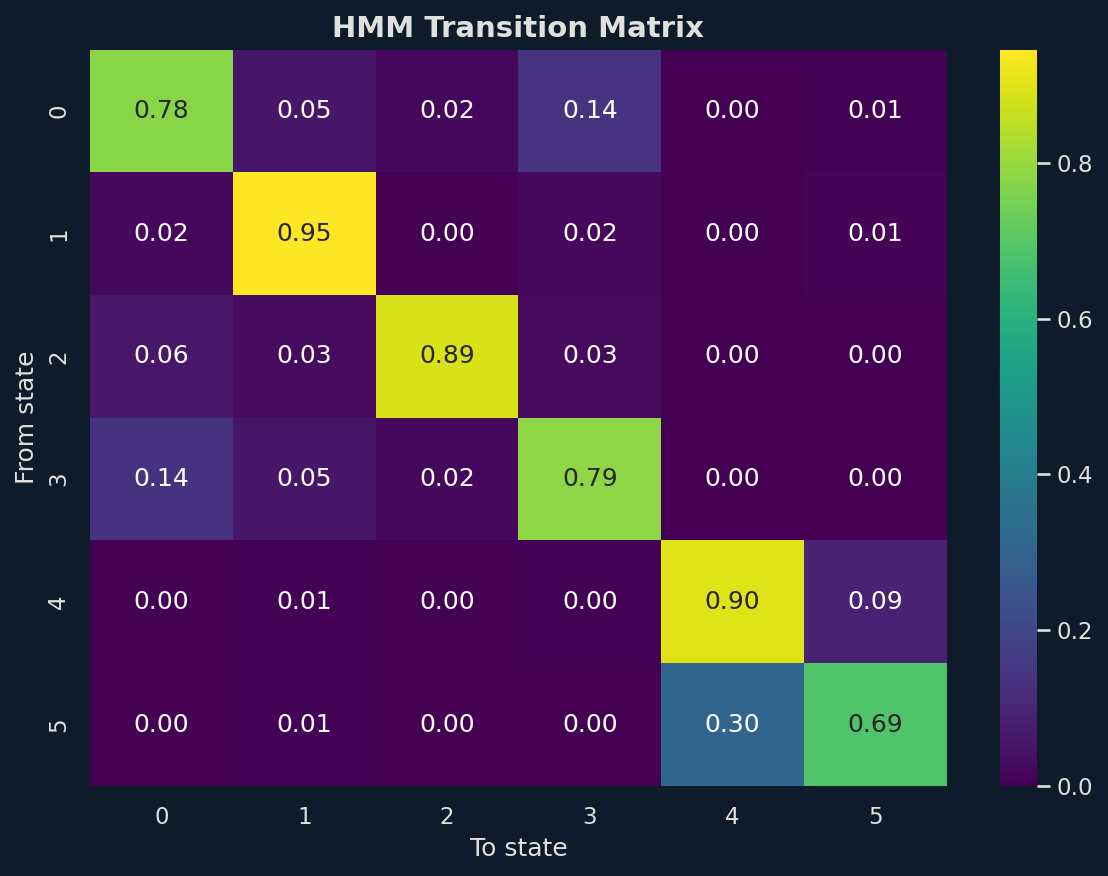

In [26]:
# Transition matrix visualization

trans_mat = model.transmat_

plt.figure(figsize=(8,6), facecolor=DARK_BG)
sns.heatmap(trans_mat, annot=True, fmt='.2f', cmap='viridis', cbar=True)
plt.title('HMM Transition Matrix', fontsize=14, fontweight='bold', color=FG)
plt.xlabel('To state', color=FG)
plt.ylabel('From state', color=FG)
plt.tight_layout()
plt.savefig("hmm_transition_matrix_dark.png", dpi=300, bbox_inches='tight', facecolor=plt.gcf().get_facecolor())
plt.show()

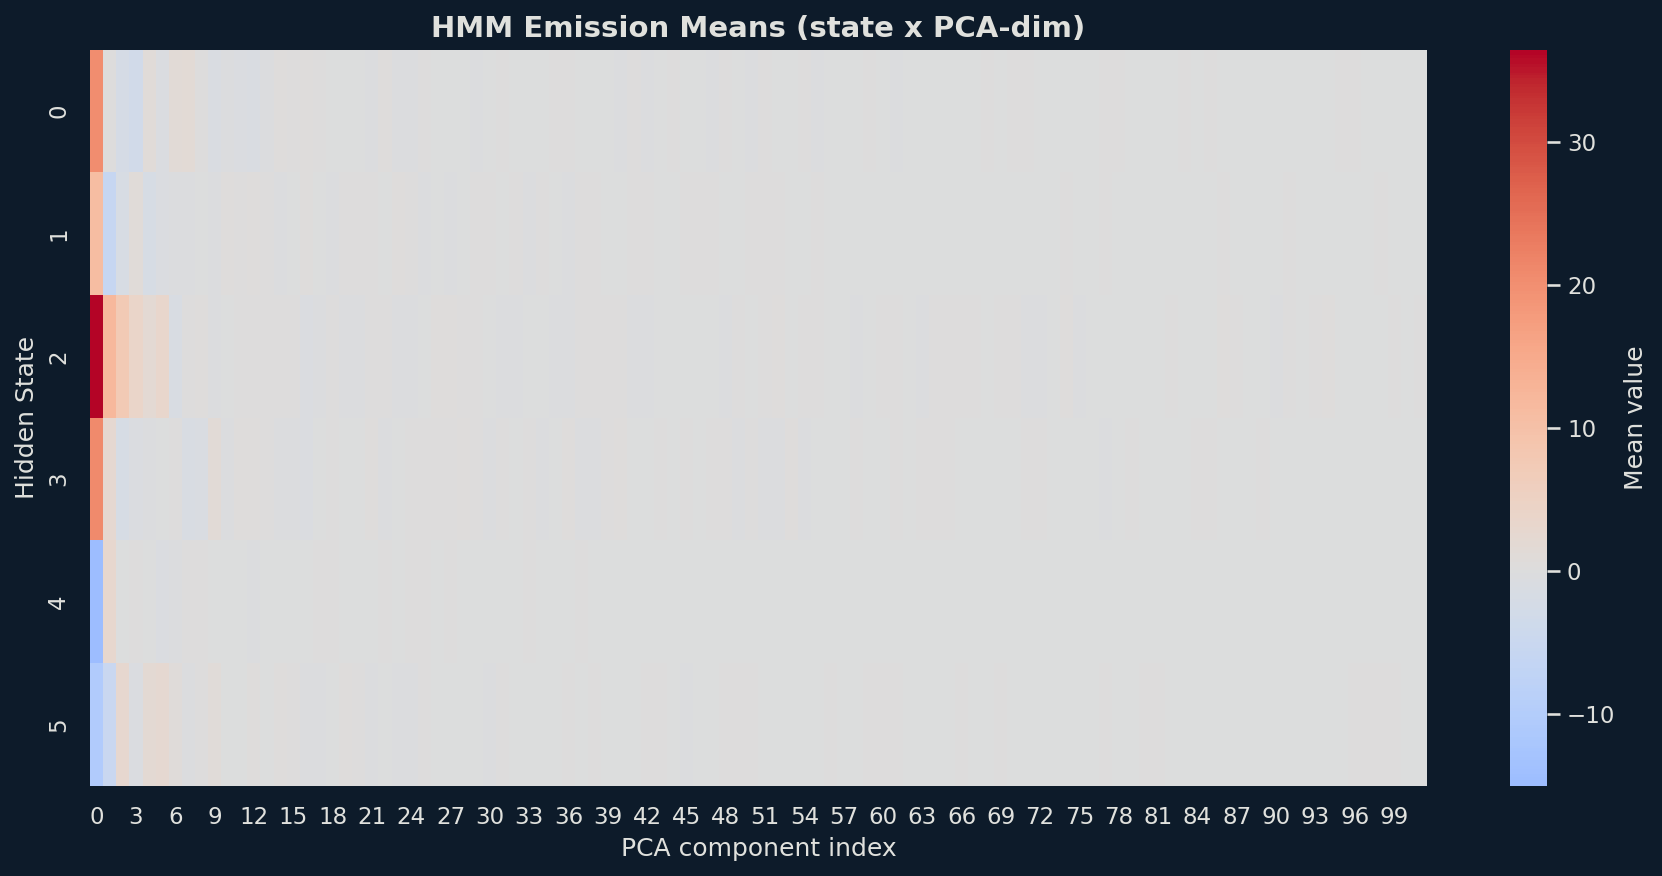

In [27]:
# X-Factor 2 — Emission means per hidden state

means = model.means_  # shape: (n_states, n_features)
plt.figure(figsize=(12,6), facecolor=DARK_BG)
sns.heatmap(means, cmap='coolwarm', center=0, cbar_kws={'label':'Mean value'})
plt.title('HMM Emission Means (state x PCA-dim)', fontsize=14, fontweight='bold', color=FG)
plt.xlabel('PCA component index', color=FG)
plt.ylabel('Hidden State', color=FG)
plt.tight_layout()
plt.savefig("hmm_emission_means_dark.png", dpi=300, bbox_inches='tight', facecolor=plt.gcf().get_facecolor())
plt.show()

In [28]:
# Decode sequences (Viterbi) and map states -> activities
# -------------------------
print("\nDecoding sequences per subject (Viterbi) and mapping states -> activities ...")
state_sequences = []
start = 0
for length in lengths:
    seq = X_concat[start:start+length]
    states = model.predict(seq)
    state_sequences.append(states)
    start += length

# Map hidden states to activities by majority vote within each state's assigned frames
# Create mapping: state -> most common true activity among frames assigned to that state
state_activity_counter = {s: Counter() for s in range(n_states)}
start = 0
for subj_idx, length in enumerate(lengths):
    true_labels = groups[subj_idx][:, :0]  # dummy to keep shape; we'll get true labels from pca_train_df slices
    subj = subjects[subj_idx]
    true_acts = pca_train_df[pca_train_df['subject']==subj]['Activity'].values
    states = state_sequences[subj_idx]
    for st, act in zip(states, true_acts):
        state_activity_counter[st][act] += 1

# Build mapping and compute purity per state
state2activity = {}
state_purity = {}
for s, counter in state_activity_counter.items():
    if len(counter)==0:
        state2activity[s] = None
        state_purity[s] = 0.0
    else:
        most_common_act, cnt = counter.most_common(1)[0]
        total = sum(counter.values())
        purity = cnt / total
        state2activity[s] = most_common_act
        state_purity[s] = purity

# Print mapping summary
print("\nState -> Mapped Activity (top mapping and purity):")
for s in range(n_states):
    print(f" State {s:02d} -> {state2activity[s]} (purity={state_purity[s]:.3f})")

# -------------------------
# Evaluate mapping: reconstruct activity labels via mapped states and compute accuracy
# -------------------------
mapped_preds = []
true_all = []
for subj_idx, states in enumerate(state_sequences):
    mapped = [state2activity[s] if state2activity[s] is not None else -1 for s in states]
    mapped_preds.extend(mapped)
    subj = subjects[subj_idx]
    true_labels = pca_train_df[pca_train_df['subject']==subj]['Activity'].values
    true_all.extend(true_labels)

mapped_preds = np.array(mapped_preds)
true_all = np.array(true_all)

# compute mapping accuracy (only for frames where mapping exists)
valid_mask = mapped_preds != -1
mapping_accuracy = np.mean(mapped_preds[valid_mask] == true_all[valid_mask])
print(f"\nMapping accuracy (HMM states -> activity via majority mapping): {mapping_accuracy:.4f}")



Decoding sequences per subject (Viterbi) and mapping states -> activities ...

State -> Mapped Activity (top mapping and purity):
 State 00 -> 4 (purity=0.799)
 State 01 -> 5 (purity=0.558)
 State 02 -> 4 (purity=0.582)
 State 03 -> 3 (purity=0.631)
 State 04 -> 0 (purity=0.343)
 State 05 -> 0 (purity=0.357)

Mapping accuracy (HMM states -> activity via majority mapping): 0.4706


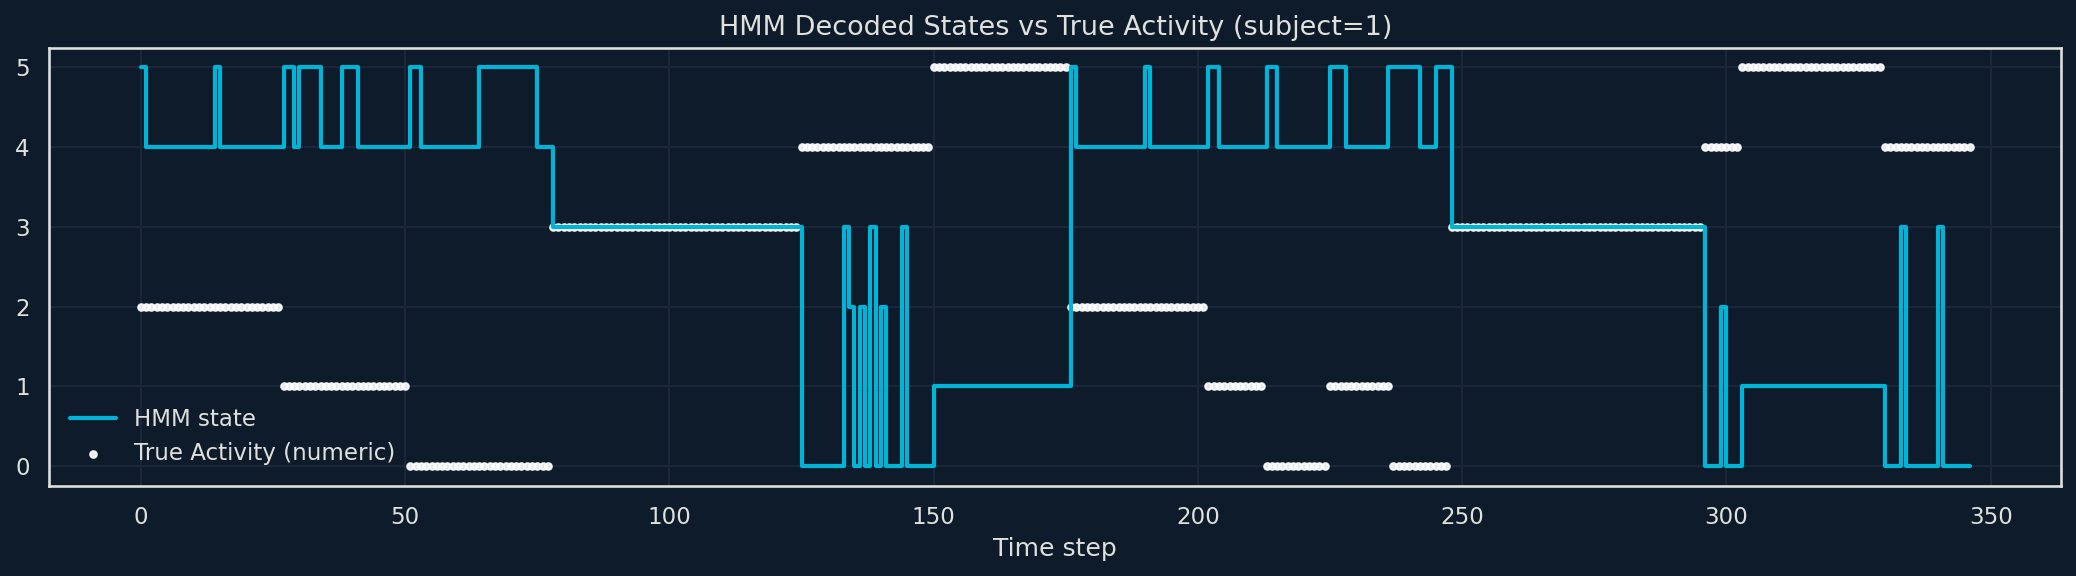

In [29]:
#  Example decoded timeline (pick one subject) 
# -------------------------
example_idx = 0
example_subject = subjects[example_idx]
example_states = state_sequences[example_idx]
example_true = pca_train_df[pca_train_df['subject']==example_subject]['Activity'].values
t = np.arange(len(example_states))

plt.figure(figsize=(14,4), facecolor=DARK_BG)
plt.plot(t, example_states, drawstyle='steps-post', color=ACCENTS[0], linewidth=2, label='HMM state')
plt.scatter(t, example_true, c='white', s=10, alpha=0.9, label='True Activity (numeric)')
plt.yticks(color=FG)
plt.title(f'HMM Decoded States vs True Activity (subject={example_subject})', fontsize=13, color=FG)
plt.xlabel('Time step', color=FG)
plt.legend(facecolor='#1B263B', edgecolor=FG)
plt.tight_layout()
plt.savefig(f"hmm_decoded_example_subject_{example_subject}_dark.png", dpi=300, bbox_inches='tight', facecolor=plt.gcf().get_facecolor())
plt.show()



Computing sequence log-likelihoods (per subject) to flag anomalous sessions ...
Mean log-likelihood: -37681.66; std: 3043.56; anomaly threshold: -43768.79
Flagged 1 anomalous sessions out of 21 subjects


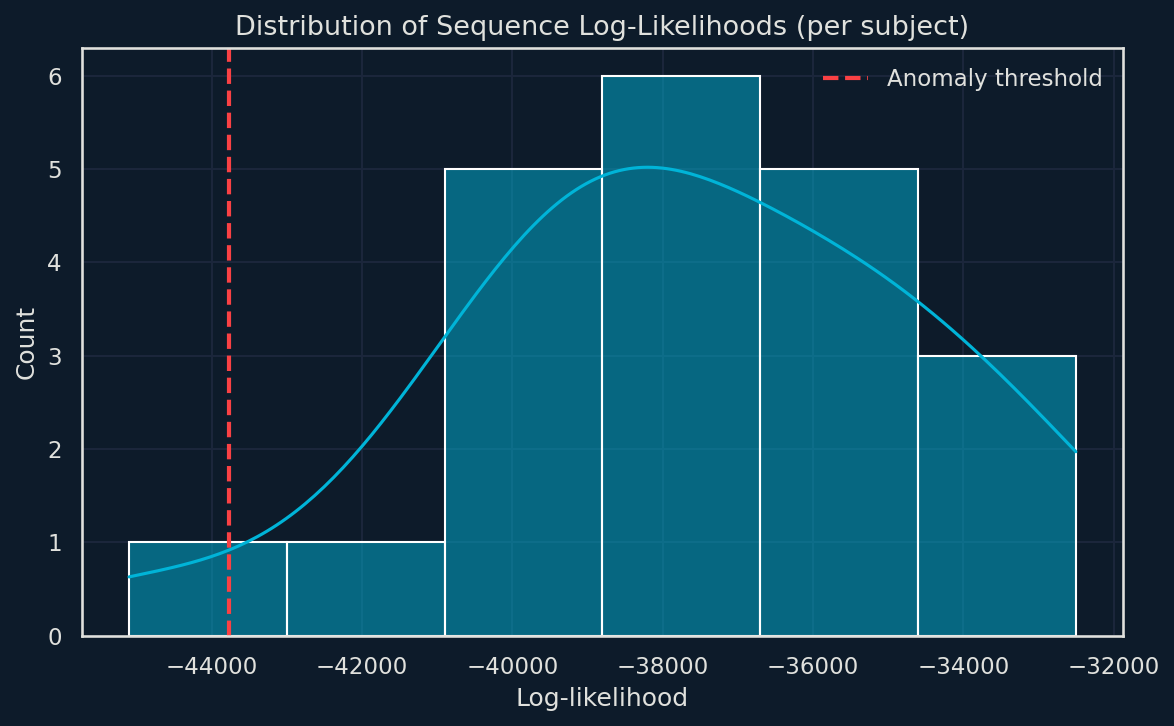


Example anomalous subject IDs (first 5):
 - 25


In [30]:
# Session anomaly detection via sequence log-likelihood
# -------------------------
print("\nComputing sequence log-likelihoods (per subject) to flag anomalous sessions ...")
loglikes = []
for seq in groups:
    loglikes.append(model.score(seq))

loglikes = np.array(loglikes)
mean_ll = loglikes.mean()
std_ll = loglikes.std()
threshold = mean_ll - 2*std_ll  # sessions below this are anomalous

anomalous_idx = np.where(loglikes < threshold)[0]
print(f"Mean log-likelihood: {mean_ll:.2f}; std: {std_ll:.2f}; anomaly threshold: {threshold:.2f}")
print(f"Flagged {len(anomalous_idx)} anomalous sessions out of {len(groups)} subjects")

# Visualize distribution of log-likelihoods
plt.figure(figsize=(8,5), facecolor=DARK_BG)
sns.histplot(loglikes, kde=True, color=ACCENTS[0])
plt.axvline(threshold, color='#F94144', linestyle='--', linewidth=2, label='Anomaly threshold')
plt.title('Distribution of Sequence Log-Likelihoods (per subject)', color=FG, fontsize=13)
plt.xlabel('Log-likelihood', color=FG)
plt.ylabel('Count', color=FG)
plt.legend(facecolor='#1B263B', edgecolor=FG)
plt.tight_layout()
plt.savefig("hmm_loglikelihood_distribution_dark.png", dpi=300, bbox_inches='tight', facecolor=plt.gcf().get_facecolor())
plt.show()

if len(anomalous_idx) > 0:
    print("\nExample anomalous subject IDs (first 5):")
    for idx in anomalous_idx[:5]:
        print(" -", subjects[idx])

In [31]:
# Save model insights (mapping and state purity) as CSV for report

mapping_df = pd.DataFrame({
    'state': list(state2activity.keys()),
    'mapped_activity': [state2activity[s] for s in state2activity],
    'purity': [state_purity[s] for s in state_purity]
})
mapping_df.to_csv("hmm_state_mapping_and_purity.csv", index=False)
print("\nSaved state mapping and purity -> hmm_state_mapping_and_purity.csv")

print("\nHMM analysis complete. X-factor highlights:")
print(" • Transition matrix and emission means reveal temporal patterns between hidden states.")
print(" • State -> activity purity provides a way to interpret hidden states semantically.")
print(" • Anomaly detection via low sequence log-likelihood can flag suspicious sessions (sensor faults, unusual behaviour).")
print(" • You can use HMM-decoded states to smooth noisy classifier predictions or create a hybrid pipeline.")
print("="*70)



Saved state mapping and purity -> hmm_state_mapping_and_purity.csv

HMM analysis complete. X-factor highlights:
 • Transition matrix and emission means reveal temporal patterns between hidden states.
 • State -> activity purity provides a way to interpret hidden states semantically.
 • Anomaly detection via low sequence log-likelihood can flag suspicious sessions (sensor faults, unusual behaviour).
 • You can use HMM-decoded states to smooth noisy classifier predictions or create a hybrid pipeline.
